In [24]:
import numpy as np
import pandas as pd
from google.colab import files
# %pip install -i https://pypi.gurobi.com gurobipy
# from gurobipy import *
import io
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
uploaded = files.upload()

Saving 48industrydaily_cleaned.csv to 48industrydaily_cleaned.csv


In [46]:
# Read the CSV file into a DataFrame: df
file_path = r'48industrydaily_cleaned.csv'
df = pd.read_csv(io.BytesIO(uploaded[file_path]), delimiter=",", skiprows=9, index_col=None, engine='python')

### 0. Filter dataset, take 63 observations before date 2021-01-04.


In [47]:
# Convert date intro right type to set index afterwards
df = df.rename(columns={'Unnamed: 0': 'Date'})
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

#Set index to date to have simpler slicing method
df = df.set_index("Date")

### 1. Choose 6 industries (from 48) and build portfolios for 2021-01-04.


In [48]:
#Take 63 observations before the target date and create dummy df for Q4

n_train = 63
train_end_idx = 24958

dummy = df.copy()

df_train = df[df.index <= "2021-04-01"]
df_train = df_train.iloc[train_end_idx-n_train: train_end_idx]
df_train

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,Hlth,MedEq,Drugs,Chems,Rubbr,Txtls,BldMt,Cnstr,Steel,FabPr,Mach,ElcEq,Autos,Aero,Ships,Guns,Gold,Mines,Coal,Oil,Util,Telcm,PerSv,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.71,0.65,0.90,0.57,1.24,-1.48,1.88,0.17,0.79,-0.34,0.47,1.02,0.31,0.52,0.63,-0.62,-0.10,-1.09,0.50,-1.22,0.18,0.26,1.02,-0.27,0.62,0.16,-0.95,-0.52,1.13,-1.02,1.39,0.94,0.76,0.36,1.06,-0.08,0.85,0.49,0.20,-0.05,0.43,-0.39,0.89,0.87,1.42,-0.55,1.35,0.71
2021-01-04,-0.95,-1.02,-3.39,-2.28,-1.13,-2.97,-3.55,-1.25,-1.35,-0.38,-0.03,-1.15,-0.74,-1.30,-1.03,-3.43,-1.93,-2.26,-0.99,-0.39,-0.96,-1.21,2.07,-4.40,-1.62,-2.76,5.41,2.01,3.25,0.22,-2.32,-1.24,-2.84,-1.66,-1.51,-1.85,-0.35,-1.48,-2.53,-2.21,-1.86,-0.91,-3.00,-1.08,-1.39,-3.33,-1.21,-1.69
2021-01-05,1.06,0.10,-0.66,0.39,0.61,2.91,0.83,0.78,0.69,1.17,1.28,1.17,0.52,3.21,1.61,2.03,1.25,0.06,4.22,3.46,1.74,1.83,1.08,2.56,1.46,1.47,0.58,2.45,4.46,4.94,0.31,-0.19,1.64,0.48,0.56,1.47,1.43,0.39,1.12,1.46,1.31,0.66,0.97,0.46,-0.41,1.48,0.55,0.32
2021-01-06,5.59,0.77,-2.66,-0.28,0.71,0.45,-1.57,3.69,0.93,1.82,2.99,0.70,0.74,3.83,3.06,3.77,4.14,2.89,7.70,6.65,3.79,6.42,2.99,0.87,5.57,0.38,2.54,5.19,1.81,2.94,2.65,1.19,1.36,-1.53,0.91,-1.92,2.04,2.03,3.60,1.42,3.49,-0.06,0.93,4.27,4.09,2.62,4.00,2.03
2021-01-07,1.64,-0.42,-0.27,0.29,0.70,5.99,0.90,-2.10,-0.49,1.40,2.06,0.87,1.67,1.45,2.19,0.73,1.52,2.85,-1.04,2.85,2.30,2.16,6.31,0.45,1.50,-1.22,-0.31,2.53,-0.05,1.54,-1.11,0.10,0.71,2.42,1.79,3.42,2.74,-1.24,-0.35,1.37,1.67,0.63,0.36,1.63,1.16,1.66,1.69,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,2.22,1.66,2.12,2.19,3.12,-0.01,0.53,0.07,1.70,2.95,0.78,1.81,1.19,2.15,1.49,1.57,2.57,3.80,7.11,3.77,3.14,3.39,-2.04,0.20,1.33,1.01,2.62,4.91,4.11,2.63,0.64,-1.57,2.33,1.54,3.60,2.14,3.41,1.20,1.15,2.31,2.24,1.28,1.06,2.04,1.10,2.66,1.43,1.95
2021-03-29,-0.50,0.58,1.22,1.29,0.10,-1.82,-0.71,-1.07,0.76,-1.07,-1.74,-0.22,-0.19,-0.69,-0.09,-2.37,-1.27,-2.59,-1.85,-4.32,-1.02,-2.82,-1.19,0.49,-0.61,1.56,0.54,-1.60,-2.08,-1.39,0.82,-0.04,-1.84,-0.33,-0.74,-0.50,-0.86,0.07,0.40,-0.66,-0.91,0.13,-0.72,-1.65,0.19,-2.86,-0.80,0.04
2021-03-30,-1.54,-0.86,-1.21,-1.14,-1.87,2.00,1.05,2.20,-0.53,0.63,0.88,-0.01,-0.59,-0.10,-0.12,1.82,1.25,2.29,3.04,3.43,0.92,1.84,3.61,0.43,1.39,-0.19,-3.61,1.06,-1.71,-0.65,-0.93,0.28,0.98,-0.46,-0.73,-0.92,-0.79,-0.01,-0.41,0.72,0.65,-0.04,0.45,1.05,-0.17,1.88,-0.03,0.33


## Generate X, y

In [49]:
def generateXy(df_train, n_industries):
  """
  Function to generate X and y for fitting the data

  df_train: pd.DataFrame
  n_industries: integer

  :return:
  list(X, y)
  """

  # create w_Ew
  w_EW = [1 / n_industries for i in range(n_industries)]

  # create N
  N = np.identity(n_industries - 1)
  N = np.vstack([N, [-1 for i in range(n_industries - 1)]])

  #Do random sampling for industry selection
  df_train = df_train.sample(n=n_industries, axis='columns')
  print(f"We choose these {n_industries} industries: " + ", ".join(list(df_train.columns)))

  # transform data into df_demean
  data_demean = scale(df_train, with_std=False)

  y = np.dot(data_demean, w_EW)
  X = np.dot(data_demean, N)

  return [X, y]

In [50]:
#Here you have to define how many industries you want to generate
n_industries = 48
result = generateXy(df_train, n_industries)

We choose these 48 industries: Beer , Steel, Telcm, Guns , BldMt, BusSv, Rubbr, LabEq, FabPr, Books, Whlsl, Coal , RlEst, Smoke, Util , Toys , Cnstr, Food , Clths, Mines, Paper, Gold , Meals, Boxes, Rtail, ElcEq, Aero , Trans, Drugs, Other, Oil  , Hshld, Agric, Txtls, Soda , Ships, Autos, Chems, Fin  , Hlth , Chips, MedEq, PerSv, Banks, Insur, Mach , Comps, Fun  


## Plot MSE vs Log(Lambda/Alpha)

In [30]:
def display_plot(cv_scores, cv_scores_std, alpha_space, n, model):
    """
    Function to plot cross-validation graphs with MSE on Y-Axis and log(lambda)
    on X-Axis

    cv_scores: np.array
    cv_scores_std: np.array
    alpha_space: np.array
    n: integer
    model: 0 = Ridge or 1 = Lasso

    :return: 
    matplotlib.pyplot plot

    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.log(alpha_space), cv_scores)

    if model == 0:
      plt.title("Bias-Variance Tradeoff for Ridge with {} Industries".format(str(n)),fontsize=15)
    
    else:
      plt.title("Bias-Variance Tradeoff for Lasso with {} Industries".format(n), fontsize=15)

    std_error = cv_scores_std / np.sqrt(10)
    plt.plot(np.log(alpha_space), cv_scores + std_error, "b--")
    plt.plot(np.log(alpha_space), cv_scores - std_error, "b--")

    ax.fill_between(np.log(alpha_space), cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('Mean-Squared Errors', fontsize=15)
    ax.set_xlabel('log(Lambda)', fontsize=15)
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([np.log(alpha_space)[0], np.log(alpha_space)[-1]])
    plt.show()

## Ridge

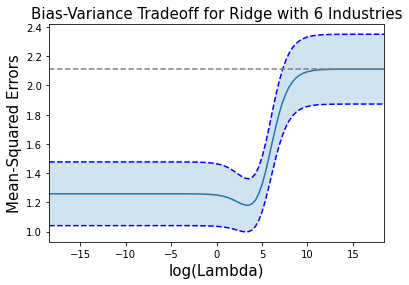

In [31]:
 def ridge_cvplot(df_train, x_y):
  """
  This function creates the cross-validation graph with ridge regressor

  df_train: pd.DataFrame
  x_y: list(X,y)

  :return:
  ridge_scores: np.array
  ridge_scores_std: np.array
  alpha_space: np.array
  ridge_best_alpha: float
  """

  X = result[0]
  y = result[1]

  # Setup the array of alphas and lists to store scores
  alpha_space = np.logspace(-8, 8, 100)
  ridge_scores = []
  ridge_scores_std = []

  # Create a ridge regressor: ridge
  ridge = Ridge()

  #Find maximum alpha score
  checker = -100000
  best_alphas = 0

  # Compute scores over range of alphas
  for alpha in alpha_space:

      # Specify the alpha value to use: ridge.alpha
      ridge.alpha = alpha
      
      # Perform 10-fold CV: ridge_cv_scores
      ridge_cv_scores = cross_val_score(ridge, X, y, cv=10, scoring='neg_mean_squared_error')

      # Find maximum alpha
      if ridge_cv_scores.mean() > checker:
        checker = ridge_cv_scores.mean()
        best_alpha = ridge.alpha

      #Find max alpha
      if ridge_cv_scores.mean() > checker:
        checker = ridge_cv_scores.mean()
        main_alpha = ridge.alpha
      
      # Append the mean of ridge_cv_scores to ridge_scores
      ridge_scores.append(np.mean(ridge_cv_scores)*-1)
      
      # Append the std of ridge_cv_scores to ridge_scores_std
      ridge_scores_std.append(np.std(ridge_cv_scores)*-1)

  return ridge_scores, ridge_scores_std, alpha_space, best_alpha

ridge_scores, ridge_scores_std, alpha_space, ridge_best_alpha = ridge_cvplot(df_train, result)

# Display the plot
display_plot(ridge_scores, ridge_scores_std, alpha_space, n_industries, 0)

In [32]:
#Best alpha received from Ridge
ridge_best_alpha

34.30469286314926

In [58]:
#Initialize Ridge with best alpha
ridge = Ridge(alpha = ridge_best_alpha)

X = result[0]
y = result[1]

ridge.fit(X,y)

#Build weights for portfolio return creation
N = np.identity(n_industries - 1)
N = np.vstack([N, [-1 for i in range(n_industries - 1)]])
beta = (ridge.coef_)
w_EW = [1 / n_industries for i in range(n_industries)]
ridge_weights = w_EW - (N.dot(beta))

ridge_weights = ridge_weights.reshape(-1, 1)

In [34]:
#RETURN ON RIDGE FIT ON 2021-01-04
ridge_weights

array([[-0.24242272],
       [ 0.22843491],
       [ 0.13078499],
       [ 0.37989676],
       [ 0.36948725],
       [ 0.13381881]])

## Lasso

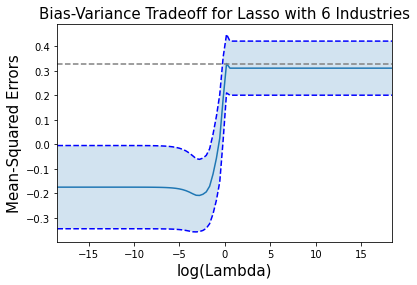

In [35]:
def lasso_cvplot(df_train, x_y):
  """
  This function creates the cross-validation graph with lasso regressor

  df_train: pd.DataFrame
  x_y: list(X,y)

  :return:
  lasso_scores: np.array
  lasso_scores_std: np.array
  alpha_space: np.array
  lasso_best_alpha: float
  """

  X = result[0]
  y = result[1]

  # Setup the array of alphas and lists to store scores
  alpha_space = np.logspace(-8, 8, 100)
  lasso_scores = []
  lasso_scores_std = []

  # Create a lasso regressor: lasso
  lasso = Lasso()

  #Find maximum alpha score
  checker = -100000
  best_alphas = 0

  # Compute scores over range of alphas
  for alpha in alpha_space:

      # Specify the alpha value to use: ridge.alpha
      lasso.alpha = alpha
      
      # Perform 10-fold CV: ridge_cv_scores
      lasso_cv_scores = cross_val_score(lasso, X, y, cv=10)

      # Find maximum alpha
      if lasso_cv_scores.mean() > checker:
        checker = lasso_cv_scores.mean()
        best_alpha = lasso.alpha
      
      # Append the mean of ridge_cv_scores to ridge_scores
      lasso_scores.append(np.mean(lasso_cv_scores)*-1)
      
      # Append the std of ridge_cv_scores to ridge_scores_std
      lasso_scores_std.append(np.std(lasso_cv_scores)*-1)

  return lasso_scores, lasso_scores_std, alpha_space, best_alpha

lasso_scores, lasso_scores_std, alpha_space, lasso_best_alpha = lasso_cvplot(df_train, result)

# Display the plot
display_plot(lasso_scores, lasso_scores_std, alpha_space, n_industries, 1)

In [36]:
lasso_best_alpha

0.061359072734131756

In [59]:
lasso = Lasso(alpha = lasso_best_alpha)

#result = generateXy(df_train , n_industries)
X = result[0]
y = result[1]

lasso.fit(X,y)

#Create weights for lasso
N = np.identity(n_industries - 1)
N = np.vstack([N, [-1 for i in range(n_industries - 1)]])
beta = (lasso.coef_)
w_EW = [1 / n_industries for i in range(n_industries)]
lasso_weights = w_EW - (N.dot(beta))
lasso_weights = lasso_weights.reshape(-1, 1)

In [38]:
#RETURN ON LASSO FIT ON 2021-01-04
lasso_weights

array([[-0.31500997],
       [ 0.16666667],
       [ 0.15297221],
       [ 0.41252517],
       [ 0.42674239],
       [ 0.15610354]])

## Mini Variance

In [52]:
reg = LinearRegression()

#result = generateXy(df_train , n_industries)
X = result[0]
y = result[1]

reg.fit(X,y)

N = np.identity(n_industries - 1)
N = np.vstack([N, [-1 for i in range(n_industries - 1)]])
beta = (reg.coef_)
w_EW = [1 / n_industries for i in range(n_industries)]
minivar_weights = w_EW - (N.dot(beta))
minivar_weights = minivar_weights.reshape(-1, 1)

In [53]:
minivar_weights

array([[-0.20995097],
       [-0.08968465],
       [-0.140499  ],
       [ 0.10285371],
       [-0.52821534],
       [-0.0383362 ],
       [ 0.08126786],
       [-0.09270608],
       [-0.07423636],
       [ 0.00871429],
       [ 0.0932059 ],
       [ 0.0219116 ],
       [ 0.06639698],
       [-0.37884441],
       [-0.27141087],
       [ 0.03343396],
       [-0.08226639],
       [-0.07542836],
       [-0.08386241],
       [-0.04956788],
       [ 0.46709744],
       [ 0.05439405],
       [ 0.20632491],
       [ 0.16592799],
       [ 0.52175931],
       [ 0.02267391],
       [ 0.02739614],
       [ 0.07565196],
       [ 0.44058765],
       [ 0.39015052],
       [ 0.09668798],
       [-0.13035277],
       [ 0.06453231],
       [-0.24372934],
       [ 0.13941846],
       [-0.10536131],
       [-0.11837331],
       [-0.18550175],
       [-0.18402406],
       [ 0.34822944],
       [-0.08248596],
       [ 0.28930839],
       [ 0.03419702],
       [ 0.35999098],
       [ 0.18698354],
       [ 0

## Construct Portfolio

In [55]:
# Q4
"""
For Question 4, onyl 48 industries should be used. As such all regressors 
have to be rerun as well as the generateXY function with 48 industries.
"""

# EW PORTFOLIO Cum return
dummy = dummy[dummy.index >= "1988-04-12"]
df_port = dummy.values
df_port = (np.where(df_port == -99.99, 0, df_port)/100)+1
EW_weights = np.array(w_EW)
EW_weights = EW_weights.reshape(-1,1)

cum_return_ew = pd.DataFrame(np.dot(df_port, EW_weights)).cumprod()
cum_return_ew.index = dummy.index
cum_return_ew

,0
Date,
1988-04-12,1.004521
1988-04-13,1.003945
1988-04-14,0.968328
1988-04-15,0.965942
1988-04-18,0.967028
...,...
2021-06-24,38.914085
2021-06-25,39.090252
2021-06-28,38.979904


In [56]:
# Min_Variance Cum return
cum_return_minivar = pd.DataFrame(np.dot(df_port, minivar_weights)).cumprod()
cum_return_minivar.index = dummy.index
cum_return_minivar

,0
Date,
1988-04-12,1.009359
1988-04-13,1.014820
1988-04-14,1.005280
1988-04-15,1.000112
1988-04-18,1.013720
...,...
2021-06-24,2.749648
2021-06-25,2.718739
2021-06-28,2.572466


In [60]:
# Ridge Cum return
cum_return_ridge = pd.DataFrame(np.dot(df_port, ridge_weights)).cumprod()
cum_return_ridge.index = dummy.index
cum_return_ridge

,0
Date,
1988-04-12,1.006082
1988-04-13,1.006373
1988-04-14,0.977626
1988-04-15,0.973357
1988-04-18,0.974871
...,...
2021-06-24,39.176649
2021-06-25,39.338598
2021-06-28,38.769460


In [61]:
# Lasso Cum return
cum_return_lasso = pd.DataFrame(np.dot(df_port, lasso_weights)).cumprod()
cum_return_lasso.index = dummy.index
cum_return_lasso

,0
Date,
1988-04-12,1.004661
1988-04-13,1.004816
1988-04-14,0.980606
1988-04-15,0.977263
1988-04-18,0.980208
...,...
2021-06-24,45.700075
2021-06-25,45.755217
2021-06-28,45.451684


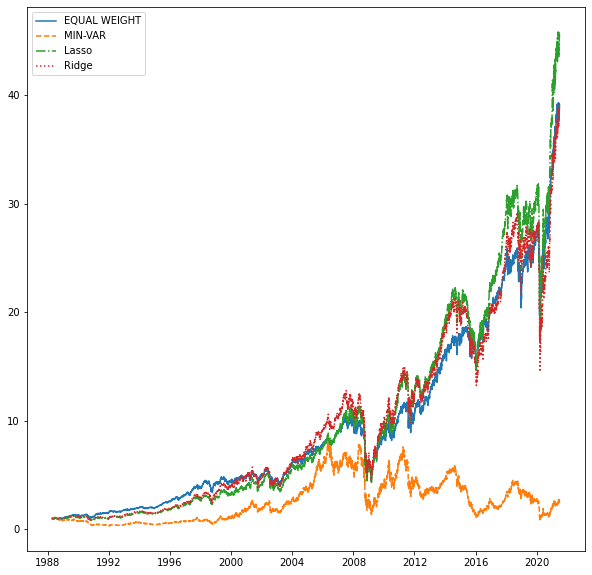

In [62]:
plt.figure(figsize=(10,10))
plt.plot(cum_return_ew, label = "EQUAL WEIGHT", linestyle="-")
plt.plot(cum_return_minivar, label = "MIN-VAR", linestyle="--")
plt.plot(cum_return_lasso, label = "Lasso", linestyle="-.")
plt.plot(cum_return_ridge, label = "Ridge", linestyle=":")
plt.legend()
plt.show()